In [1]:
# import packages
import anndata
import scanpy as sc
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib as plt
%load_ext rpy2.ipython

import math
import natsort
import pandas
import session_info

In [2]:
# load loom files
adata1 = scv.read("E105EndoLib24.loom", cache = True)
adata2 = scv.read("E105EndoWT.loom", cache = True)
adata3 = scv.read("E115PLUS.loom", cache = True)
adata1.var_names_make_unique()
adata2.var_names_make_unique()
adata3.var_names_make_unique()

In [3]:
# load meta info
sample_obs = pd.read_csv("meta/cellID_obs.csv")
cell_clusters = pd.read_csv("meta/clusters.csv", index_col = 0)
umap_cord = pd.read_csv("meta/cell_embeddings.csv")

In [4]:
# select cells and assign celltype
adata1 = adata1[np.isin(adata1.obs.index, sample_obs["x"])]
adata1.obs['celltype'] = list(cell_clusters.loc[adata1.obs.index, "x"])
adata2 = adata2[np.isin(adata2.obs.index, sample_obs["x"])]
adata2.obs['celltype'] = list(cell_clusters.loc[adata2.obs.index, "x"])
adata3 = adata3[np.isin(adata3.obs.index, sample_obs["x"])]
adata3.obs['celltype'] = list(cell_clusters.loc[adata3.obs.index, "x"])

In [5]:
# add umap coordinates
umap_cord["UMAP_1"] = umap_cord["UMAP_1"] * -1
umap_cord["UMAP_2"] = umap_cord["UMAP_2"] * -1
umap_cord = umap_cord.rename(columns = {'Unnamed: 0':'CellID'})

adata1_index = pd.DataFrame(adata1.obs.index)
adata2_index = pd.DataFrame(adata2.obs.index)
adata3_index = pd.DataFrame(adata3.obs.index)

umap_ordered_1 = adata1_index.merge(umap_cord, on = "CellID")
umap_ordered_1 = umap_ordered_1.iloc[:,1:]
adata1.obsm['X_umap'] = umap_ordered_1.values

umap_ordered_2 = adata2_index.merge(umap_cord, on = "CellID")
umap_ordered_2 = umap_ordered_2.iloc[:,1:]
adata2.obsm['X_umap'] = umap_ordered_2.values

umap_ordered_3 = adata3_index.merge(umap_cord, on = "CellID")
umap_ordered_3 = umap_ordered_3.iloc[:,1:]
adata3.obsm['X_umap'] = umap_ordered_3.values

In [6]:
# concatenate 3 samples
adata = adata1.concatenate(adata2, adata3)
adata.obs['clusters'] = adata.obs['celltype']
adata.obs['clusters'] = adata.obs['clusters'].astype('category')
adata.obs['clusters'] = adata.obs['clusters'].cat.set_categories(['VEC','AEC','pre-HEC','HEC','HSC'], ordered=True)
adata_all = adata

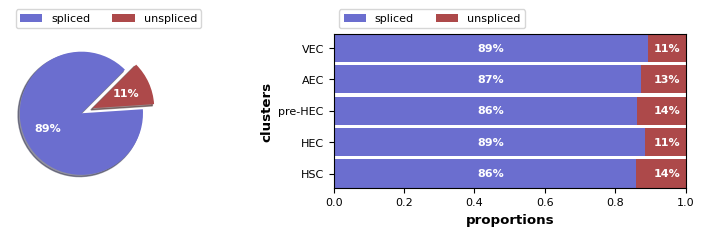

In [7]:
# the proportions of spliced/unspliced counts
scv.pl.proportions(adata)

In [8]:
# preprocess the data
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
scv.pp.log1p(adata)

Filtered out 24255 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


In [9]:
# filter, normalization and moments
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 124 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [10]:
# estimate RNA velocity
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/128 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [11]:
# umap reduction
#scv.tl.umap(adata)
pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index).to_csv("meta/X_umap.csv")

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_velocity_mouse.pdf


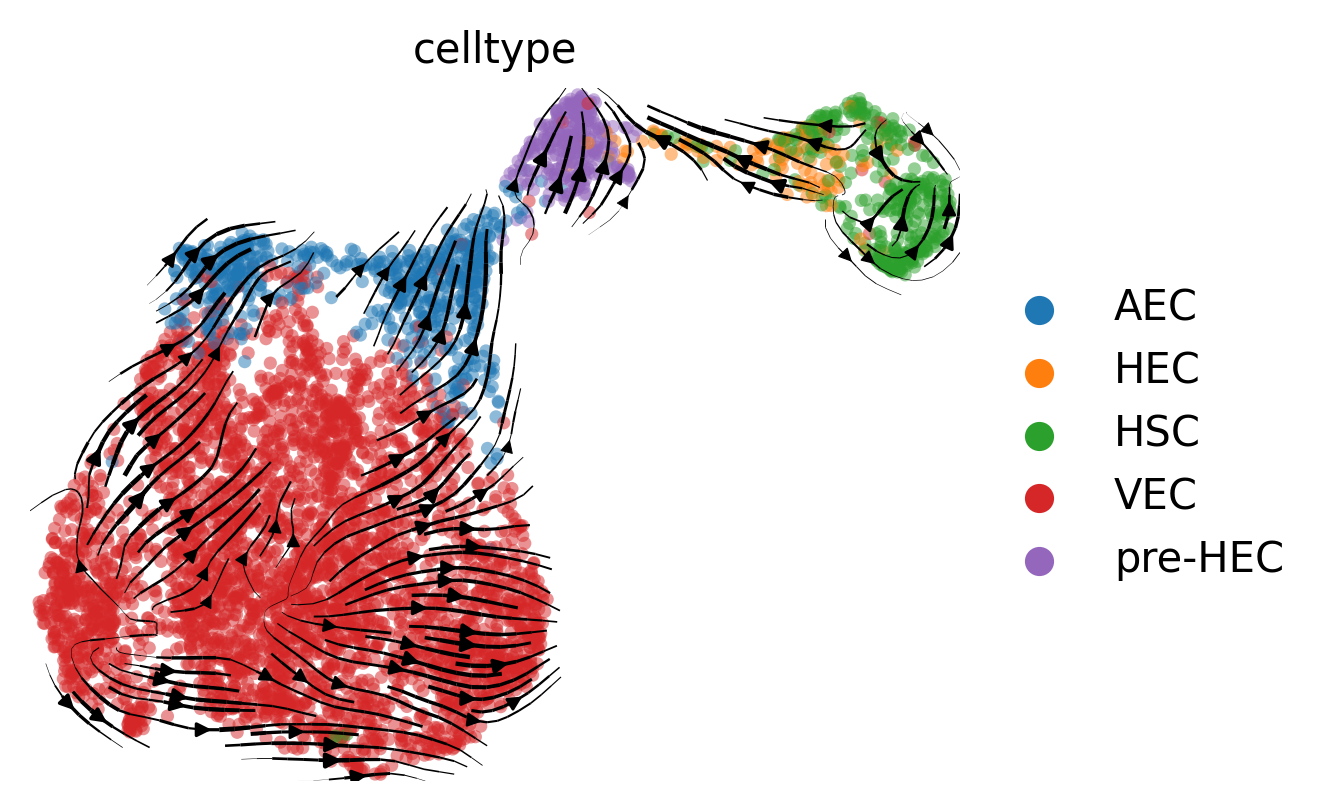

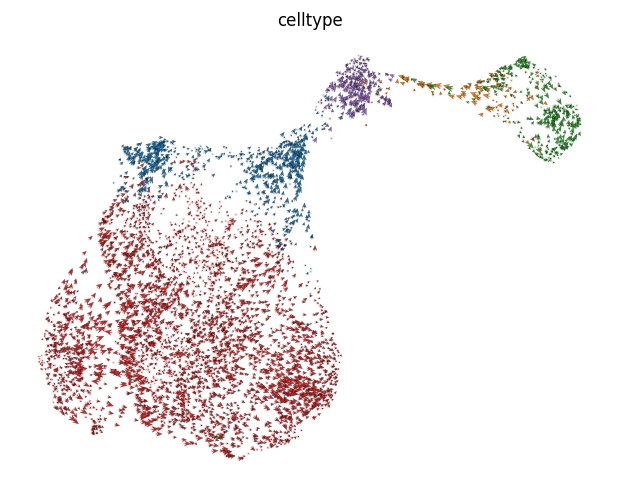

In [12]:
# project the velocities
scv.pl.velocity_embedding_stream(adata, basis="umap", color="celltype", save="velocity_mouse.pdf", dpi=300, figsize=(4,3), linewidth=0.7, arrow_size=0.7, size=40, alpha = 0.5, legend_loc="right margin")
scv.pl.velocity_embedding(adata, color="celltype", arrow_length=3, arrow_size=2, dpi=120)

saving figure to file ./figures/scvelo_marker_gene_mouse.pdf


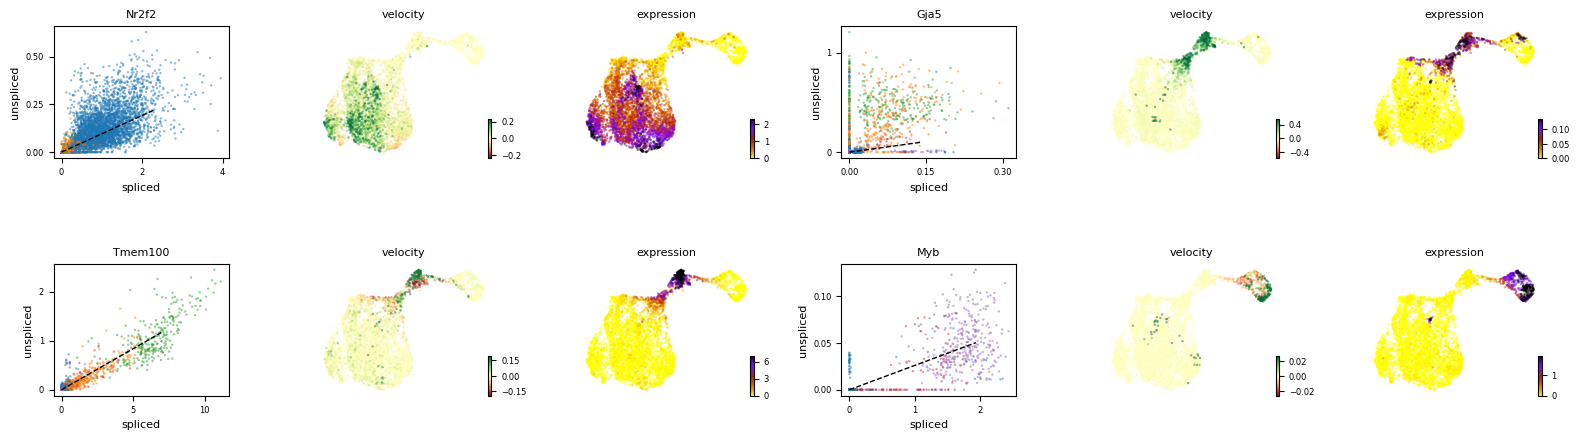

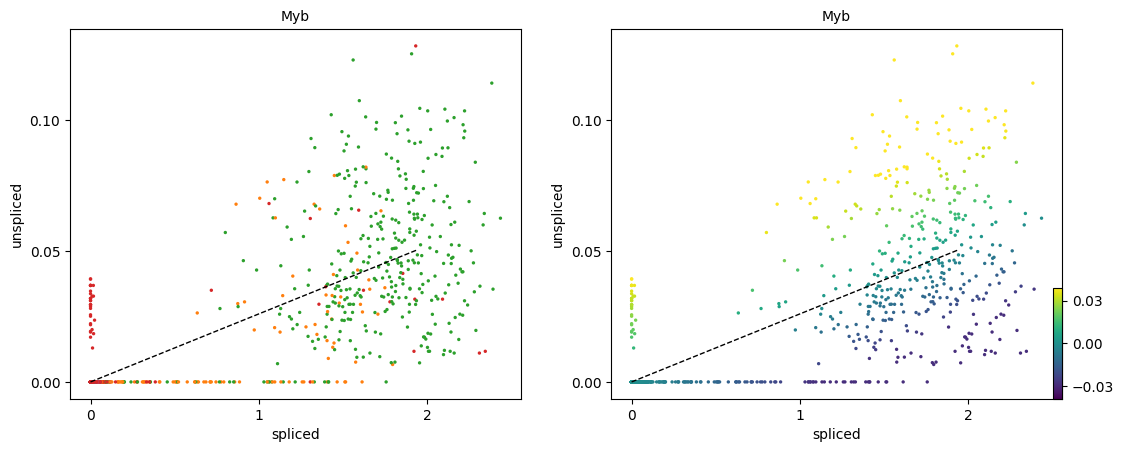

In [13]:
# phase portraits of marker genes
scv.pl.velocity(adata, ['Nr2f2', 'Gja5', "Tmem100", 'Myb'], ncols=2, save="marker_gene_mouse.pdf")
scv.pl.scatter(adata, 'Myb', color=['celltype', 'velocity'])

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


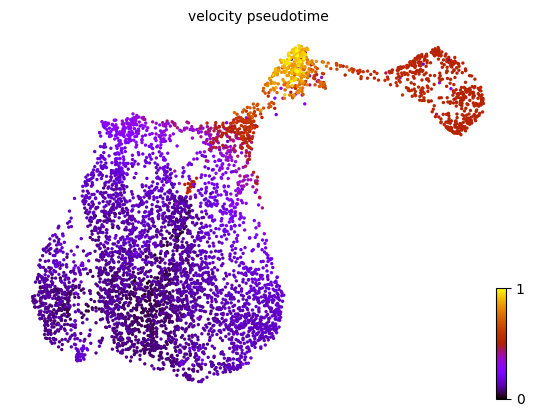

In [14]:
# pseudotime
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)
saving figure to file ./figures/scvelo_cell_cycle.pdf


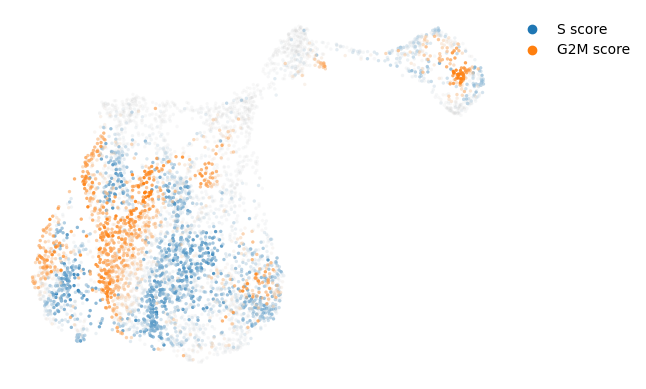

In [15]:
# cell cycle scores
cell_cycle_genes = [x.strip().capitalize() for x in open('./meta/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

scv.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95], save="cell_cycle.pdf")

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
saving figure to file ./figures/scvelo_velocity_length.pdf


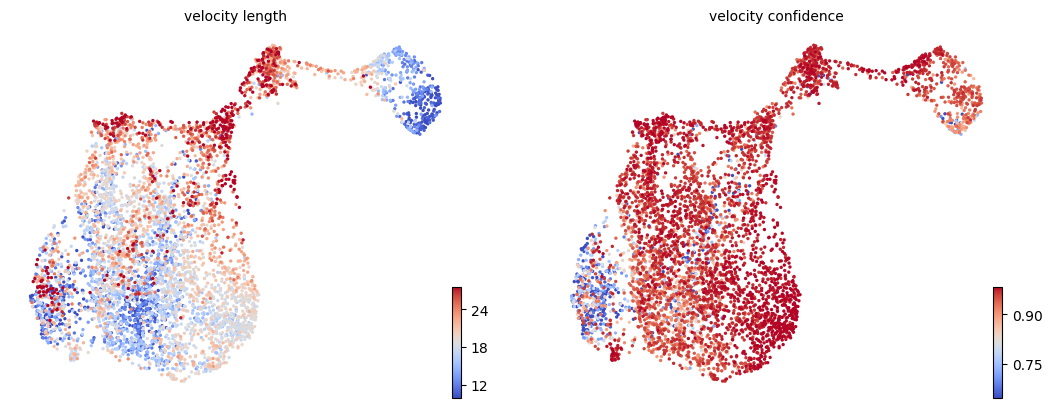

In [16]:
# speed and coherence
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], save="velocity_length.pdf")

saving figure to file ./figures/scvelo_splicing_GJA5_mouse.pdf


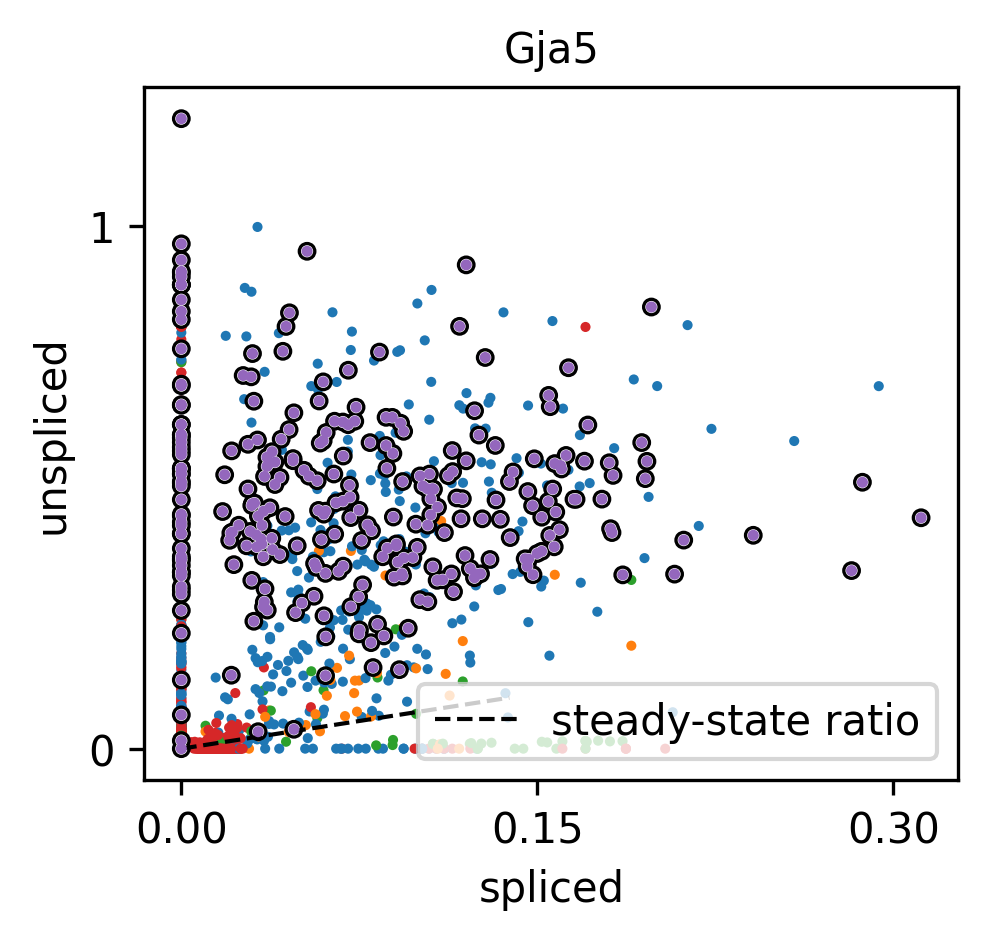

saving figure to file ./figures/scvelo_splicing_TMEM100_mouse.pdf


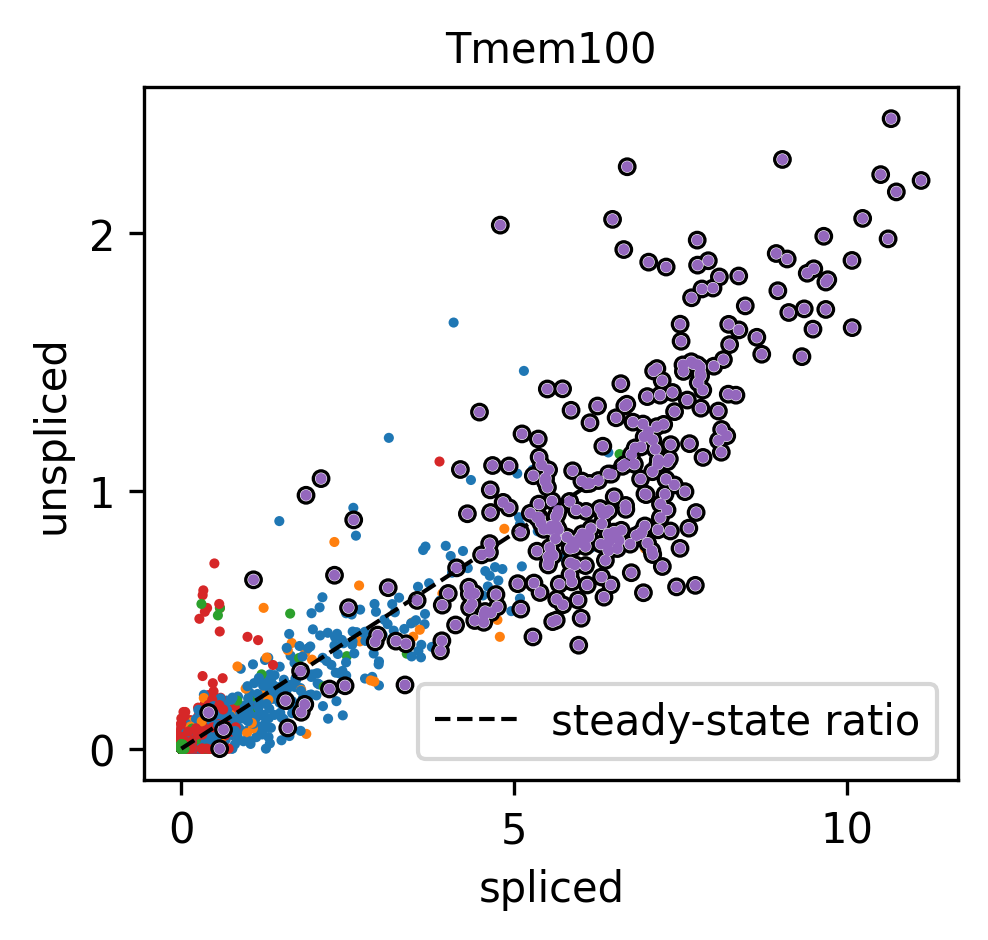

In [17]:
# plot pre-HEC markers
scv.pl.scatter(adata_all, ['Gja5'], color=['celltype'], dpi=300, figsize=(3.5,3), add_outline="pre-HEC", save="splicing_GJA5_mouse.pdf")
scv.pl.scatter(adata_all, ['Tmem100'], color=['celltype'], dpi=300, figsize=(3.5,3), add_outline="pre-HEC", save="splicing_TMEM100_mouse.pdf")

In [18]:
# save the adata
adata.write('sample_mouse_scvelo.h5ad')

In [19]:
# dynamical model
scv.tl.recover_dynamics(adata, n_jobs=10)

recovering dynamics (using 10/128 cores)
    finished (0:01:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [20]:
# estimate velocities based on dynamical model
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/128 cores)
    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [21]:
# save the adata with dynamical model
adata.write('sample_mouse_dynamical.h5ad')

computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)
saving figure to file ./figures/scvelo_latent_time.pdf


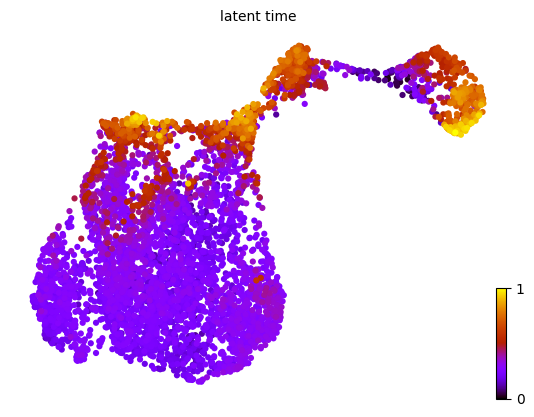

In [22]:
# predict latent time
scv.tl.latent_time(adata)
pd.DataFrame(adata.obs.latent_time).to_csv("meta/latent_time_mouse_EHT.csv")
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80, save="latent_time.pdf")

In [23]:
# get top variable genes
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
top_genes

Index(['Ikzf1', 'Spi1', 'Angpt1', 'Hlf', 'Dapp1', 'Ikzf2', 'Tmem100', 'Celf2',
       'Tcf4', 'Runx1',
       ...
       'Tceal9', 'Huwe1', 'Kdm5c', 'Acot9', 'Rps6ka3', 'Ctps2', 'Ap1s2',
       'Ddx3y', 'Eif2s3y', 'Gm47283'],
      dtype='object', name='Gene', length=1876)

In [24]:
# subset vec cluster
adata_vec = sc.pp.subsample(adata_all[adata_all.obs["celltype"].isin(["VEC"])], n_obs = 300, copy=True)
adata_eht = adata_all[adata_all.obs["celltype"].isin(["AEC", "pre-HEC", "HEC", "HSC"])]
adata_sampled = adata_vec.concatenate(adata_eht)

saving figure to file ./figures/scvelo_heatmap_heatmap.png


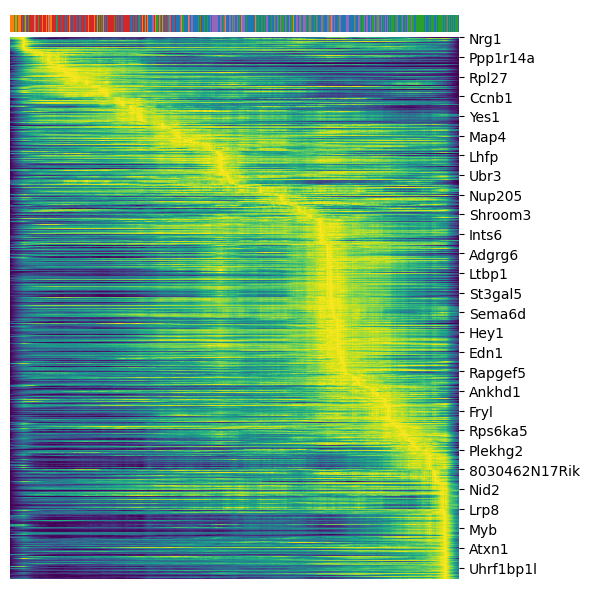

In [25]:
# plot heatmaps
# scv.pl.heatmap(adata_sampled, var_names=top_genes, sortby='latent_time', col_color='celltype', n_convolve=100, figsize=(6,6), save="heatmap.pdf")
scv.pl.heatmap(adata_sampled, var_names=top_genes, sortby='latent_time', col_color='celltype', n_convolve=100, figsize=(6,6), save="heatmap.png")

In [26]:
session_info.show()